# Section 1 of Toy Models of Superposition

In [1]:
import os
import torch
import random
from torch import nn
# from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms

In [2]:
def get_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

device = get_device()
print(f"Using {device} device")

Using mps device


## 0 Sparsity Model

In [3]:
class ToyModelNoSparsity(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.rand(2, 5), requires_grad=True)
        self.bias = nn.Parameter(torch.rand(5, 1), requires_grad=True)
        self.ReLU = nn.ReLU(inplace=True)
        
    def forward(self, x): # x is 5 * 1
        hidden = self.weights @ x
        final = self.weights.T @ hidden
        final += self.bias
        return self.ReLU(final)

class NoSparsityLoss(nn.Module):
    def __init__(self):
        super(NoSparsityLoss, self).__init__()

    def forward(self, predictions, targets, importance):
        sub_total = ((predictions - targets)**2).sum(0).flatten()
        return sum(sub_total * importance)

model = ToyModelNoSparsity().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_func = NoSparsityLoss()

In [4]:
NUM_EPOCHS = 10
BATCHS_PER_EPOCH = 1000
BATCH_SIZE = 10


def train(loss_fn, optimizer, importance, sparsity):
    probability = 1 - sparsity
    model.train()
    loss_total = 0
    for epoch in range(NUM_EPOCHS):
        for i in range(BATCHS_PER_EPOCH):
            sparsity_tensor = torch.bernoulli(torch.full((5,1), probability))
            x = torch.rand(BATCH_SIZE, 5, 1)
            x = (x*sparsity_tensor).to(device)
            pred = model(x)
            loss = loss_fn(pred, x, importance)
            loss_total += loss.item()
    
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print("EPHOCH:", epoch + 1, "--> loss:", loss_total / (BATCHS_PER_EPOCH * BATCH_SIZE))
        loss_total = 0

In [5]:
IMPORTANCE = torch.arange(1, 0, -0.2).to(device)
SPARSITY = 0

train(loss_func, optimizer, IMPORTANCE, 0.0)

EPHOCH: 1 --> loss: 0.16393068257570267
EPHOCH: 2 --> loss: 0.11825159960985183
EPHOCH: 3 --> loss: 0.11455461211204529
EPHOCH: 4 --> loss: 0.1137265843808651
EPHOCH: 5 --> loss: 0.11241153759360313
EPHOCH: 6 --> loss: 0.11124931304454803
EPHOCH: 7 --> loss: 0.10888950218856334
EPHOCH: 8 --> loss: 0.10721608261168003
EPHOCH: 9 --> loss: 0.1060317343533039
EPHOCH: 10 --> loss: 0.10510925270915031


In [6]:
print(model.weights.T)

tensor([[-1.3018e-01,  9.9098e-01],
        [-8.8648e-01, -1.4137e-01],
        [ 4.2979e-01,  3.8821e-02],
        [ 6.4635e-02,  1.0708e-02],
        [ 4.5267e-02,  7.0917e-04]], device='mps:0',
       grad_fn=<PermuteBackward0>)


In [7]:
print(model.bias)

Parameter containing:
tensor([[0.0227],
        [0.3555],
        [0.5883],
        [0.5156],
        [0.5051]], device='mps:0', requires_grad=True)


In [8]:
w = model.weights.T.to('cpu').detach()

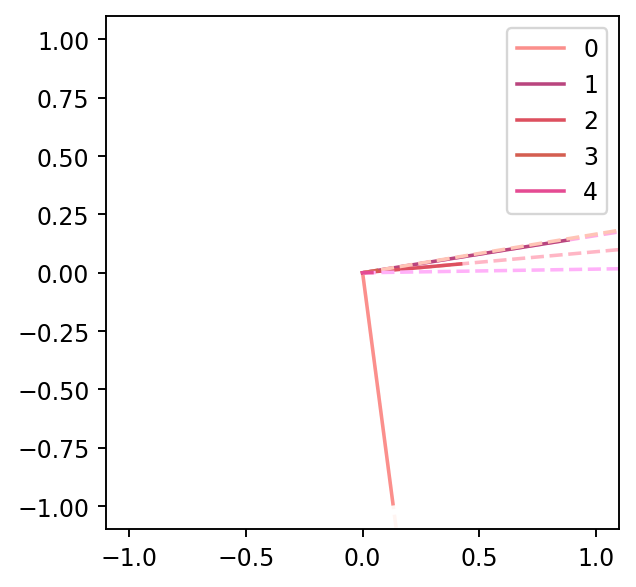

In [9]:
plt.figure(dpi=170)
plt.axis([-1.1, 1.1, -1.1, 1.1])

for i in range(5):
    w_i = w[i]
    slope = w_i[1]/w_i[0]
    
    b = slope * slope
    n = torch.norm(w_i).item()
    limit = n/torch.sqrt(1 + slope**2).item()
    
    x2 = torch.arange(start=0, end=limit + 1.5, step=0.01)
    y2 = x2 * slope
    x = torch.arange(start=0, end=limit, step=0.01)
    y = x * slope

    rand_color = (1 - random.random()/2.75, 0.6 - random.random()/2.75, 0.6 - random.random()/2.75)
    lighter_color = (min(1, rand_color[0] + 0.4), rand_color[1] + 0.4, rand_color[2] + 0.4)

    plt.plot(x2, y2, '--', color=lighter_color, linewidth=1.5, markeredgecolor='y')
    plt.plot(x, y, '-', color=rand_color, label=str(i), linewidth=1.5, markeredgecolor='y')

plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()